# Plots for omega - all models

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cftime
import datetime
import gcsfs
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import time
import xarray as xr
import zarr

### Input files

In [2]:
# UKESM
UK_filename_base = '/nird/home/julnavda/CMIP6/ssp370SST/wap/wap_Amon_UKESM1-0-LL_ssp370SST_r1i1p1f2_gn_201501-209912.nc'
UK_filename_signal = '/nird/home/julnavda/CMIP6/ssp370SST-lowBC/wap/wap_Amon_UKESM1-0-LL_ssp370SST-lowBC_r1i1p1f2_gn_201501-209912.nc'

UKESM_base = xr.open_dataset(UK_filename_base)
UKESM_signal = xr.open_dataset(UK_filename_signal)

# MIROC6
MIR_filename_base = '/nird/home/julnavda/CMIP6/ssp370SST/wap/wap_Amon_MIROC6_ssp370SST_r1i1p1f1_gn_201501-209912.nc'
MIR_filename_signal = '/nird/home/julnavda/CMIP6/ssp370SST-lowBC/wap/wap_Amon_MIROC6_ssp370SST-lowBC_r1i1p1f1_gn_201501-205512.nc'

MIROC_base = xr.open_dataset(MIR_filename_base)
MIROC_signal = xr.open_dataset(MIR_filename_signal)

# MPI-ESM
MPI_filename_base = '/nird/home/julnavda/CMIP6/ssp370SST/wap/wap_Amon_MPI-ESM-1-2-HAM_ssp370SST_r1i1p1f1_gn_201501-205512.nc'
MPI_filename_signal = '/nird/home/julnavda/CMIP6/ssp370SST-lowBC/wap/wap_Amon_MPI-ESM-1-2-HAM_ssp370SST-lowBC_r1i1p1f1_gn_201501-205512.nc'

MPI_ESM_base = xr.open_dataset(MPI_filename_base)
MPI_ESM_signal = xr.open_dataset(MPI_filename_signal)

In [3]:
UKESM_base

<xarray.Dataset>
Dimensions:    (time: 1020, bnds: 2, lon: 192, lat: 144, plev: 19)
Coordinates:
  * time       (time) object 2015-01-16 00:00:00 ... 2099-12-16 00:00:00
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * plev       (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lon_bnds   (lon, bnds) float64 ...
    lat_bnds   (lat, bnds) float64 ...
    wap        (time, plev, lat, lon) float32 ...
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.1.0 (https://mpi...
    source:                 UKESM1.0-LL (2018): \naerosol: UKCA-GLOMAP-mode\n...
    institution:            Natural Environment Research Council, STFC-RAL, H...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            AerChemMIP
    branch_method:          standard
    ...                     ...
    variable_name:          wap
    variant_label:          r1i1p1f2
    license:                CMIP6 model data produced by the Natural Environm...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/b5f944d3-65dd-4ab1-b3c0-4c7110a4a7de
    CDO:                    Climate Data Operators version 2.1.0 (https://mpi...

### Define functions and limits

In [4]:
def slice_plev(ds):
    ds = ds.sel(plev=85000.0) # 850 hPa
    return ds

MIROC_base_850, MIROC_signal_850 = slice_plev(MIROC_base), slice_plev(MIROC_signal)
MPI_ESM_base_850, MPI_ESM_signal_850 = slice_plev(MPI_ESM_base), slice_plev(MPI_ESM_signal)
UKESM_base_850, UKESM_signal_850 = slice_plev(UKESM_base), slice_plev(UKESM_signal)

In [5]:
def slice_plev(ds):
    ds = ds.sel(plev=25000.0) # 250 hPa
    return ds

MIROC_base_250, MIROC_signal_250 = slice_plev(MIROC_base), slice_plev(MIROC_signal)
MPI_ESM_base_250, MPI_ESM_signal_250 = slice_plev(MPI_ESM_base), slice_plev(MPI_ESM_signal)
UKESM_base_250, UKESM_signal_250 = slice_plev(UKESM_base), slice_plev(UKESM_signal)

In [6]:
def calculate_anomaly(start_year, end_year, ds1, ds2):
    """Calculates the anomaly between two datasets within a specific timeframe"""
    ds1_slice = ds1.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"))
    ds2_slice = ds2.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-20"))
    
    mean1 = ds1_slice['wap'].mean(dim='time')
    mean2 = ds2_slice['wap'].mean(dim='time')
    
    # Invert the vertical mass flux (make it positive upwards)
    return -(mean2 - mean1)

In [7]:
def calculate_seasonal_anomaly(start_year, end_year, dataset1, dataset2, season):
    start_date = f"{start_year}-01-01"
    end_date = f"{end_year}-12-30"  

    # Filter datasets by season
    ds1_seasonal = dataset1.sel(time=slice(start_date, end_date))
    ds1_seasonal = ds1_seasonal.sel(time=ds1_seasonal['time'].dt.season == season)

    ds2_seasonal = dataset2.sel(time=slice(start_date, end_date))
    ds2_seasonal = ds2_seasonal.sel(time=ds2_seasonal['time'].dt.season == season)

    # Calculate means for the specific season
    mean1 = ds1_seasonal.mean(dim='time')
    mean2 = ds2_seasonal.mean(dim='time')

    return -(mean2['wap'] - mean1['wap'])

In [8]:
def calculate_annual_means(dataset, start_year, end_year):
    start_date = f"{start_year}-01-01"
    end_date = f"{end_year}-12-30"
    return dataset.sel(time=slice(start_date, end_date)).resample(time='A').mean(dim='time')

### Define Intervals

In [9]:
UKESM_intervals = [(2015, 2034), (2035,2054), (2055, 2074), (2075, 2094)]
MIROC6_intervals = [(2015, 2034), (2035,2054)]
MPI_ESM_intervals = [(2015, 2034), (2035,2054)]

### Define min and max values for the cmap

In [10]:
V_MIN, V_MAX = -0.03, 0.03

### Define the color map

In [11]:
cmap = mpl.colormaps['RdBu_r']
norm = mcolors.TwoSlopeNorm(vmin=V_MIN, vcenter=0, vmax=V_MAX)

# South and East Asia

### 850 hPa

In [12]:
UKESM_anomalies = [calculate_anomaly(start, end, UKESM_base_850, UKESM_signal_850) for start, end in UKESM_intervals]
MIROC6_anomalies = [calculate_anomaly(start, end, MIROC_base_850, MIROC_signal_850) for start, end in MIROC6_intervals]
MPI_ESM_anomalies = [calculate_anomaly(start, end, MPI_ESM_base_850, MPI_ESM_signal_850) for start, end in MPI_ESM_intervals]

/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/scipy/stats/_mstats_basic.py:1438: RuntimeWarning: divide by zero encountered in divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/scipy/stats/_mstats_basic.py:1438: RuntimeWarning: divide by zero encountered in divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/scipy/stats/_mstats_basic.py:1438: RuntimeWarning: divide by zero encountered in divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/scipy/stats/_mstats_basic.py:1438: RuntimeWarning: divide by zero encountered in divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/scipy/stats/_mstats_

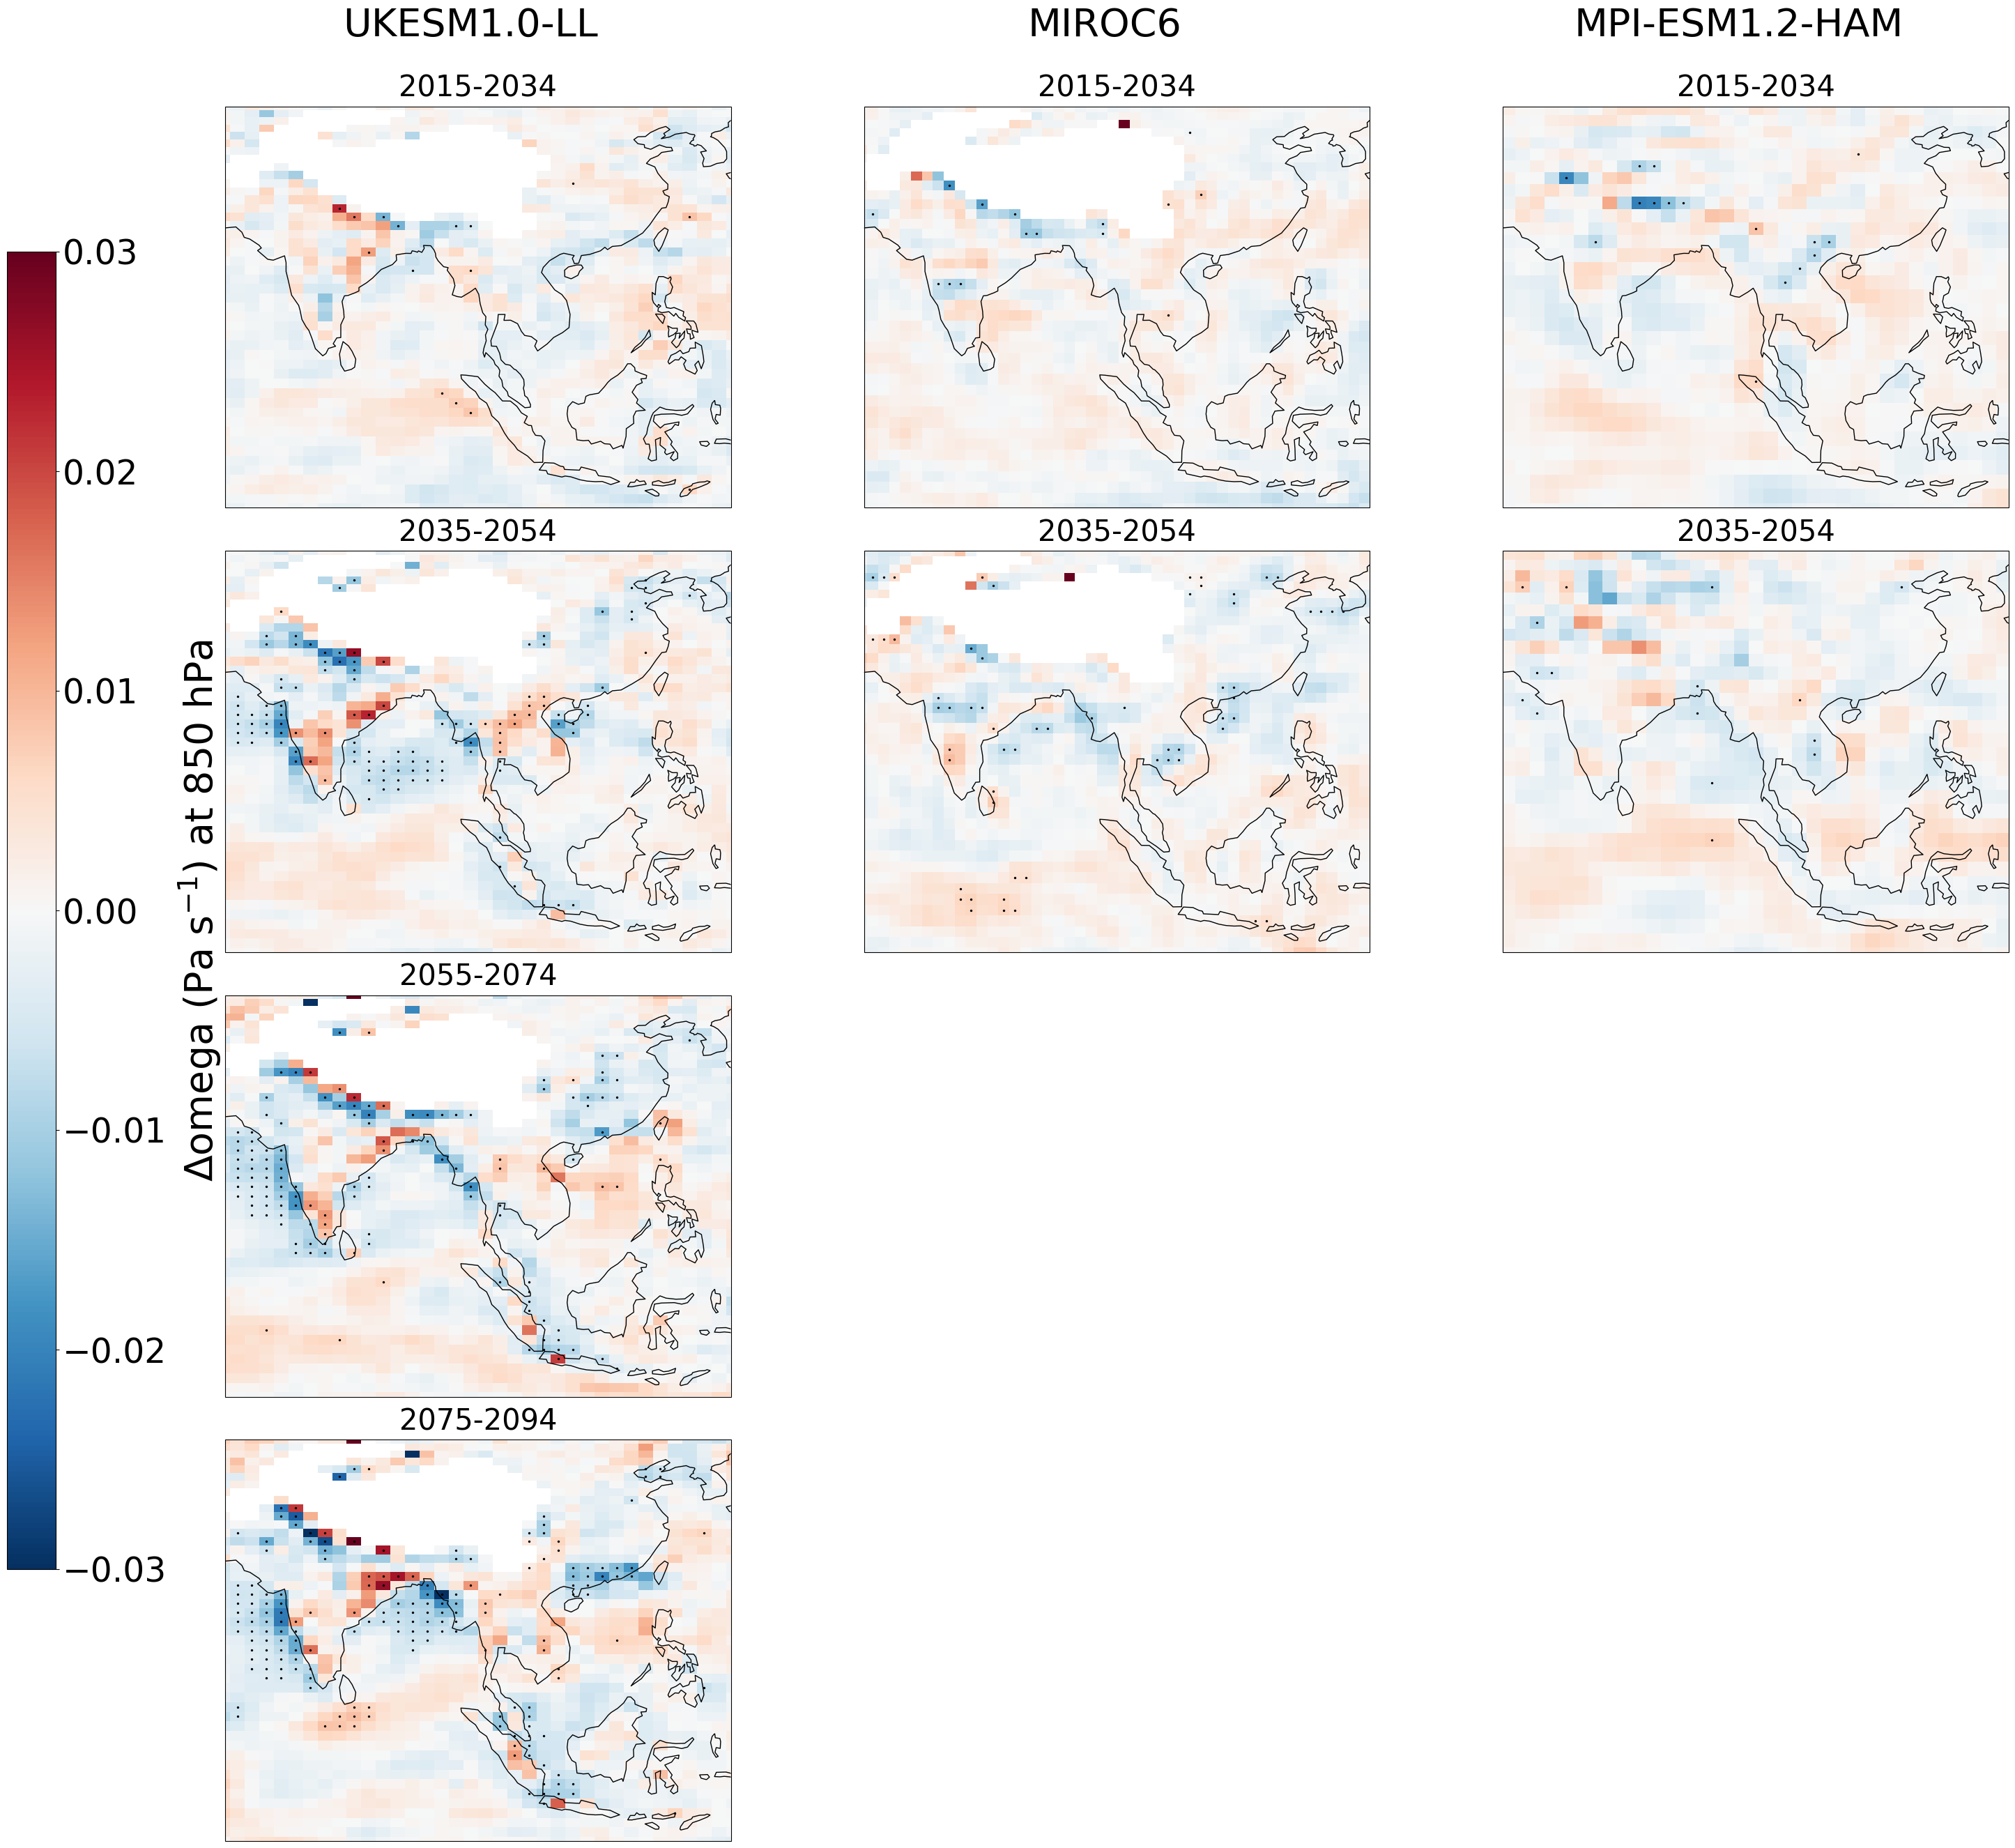

In [13]:
# Create the grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(35, 27), subplot_kw={'projection': ccrs.LambertCylindrical()})
axes = axes.T  # Transpose to get the desired column layout

# Function to plot data
def plot_data(ax, anomaly, title, ds_base, ds_signal, start_year, end_year):
    # Set geographical extents [lon_min, lon_max, lat_min, lat_max]
    ax.set_extent([65, 130, -10, 40])
    im = anomaly.plot(ax=ax, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)
    ax.coastlines()
    ax.set_title(title, fontsize=30, pad=10)
    
    annual_means_base = calculate_annual_means(ds_base, start_year, end_year)
    annual_means_signal = calculate_annual_means(ds_signal, start_year, end_year)
    
    # Select regional-annual data for the t-test
    regional_base = annual_means_base.sel(lon=slice(65, 130), lat=slice(-10, 40))
    regional_signal = annual_means_signal.sel(lon=slice(65, 130), lat=slice(-10, 40))
    
    t_stat, p_value = ttest_ind(regional_base['wap'].values,
                                regional_signal['wap'].values,
                                axis=0, nan_policy='omit')

    alpha = 0.05
    significant_points_mask = p_value < alpha

    lon, lat = np.meshgrid(regional_base['lon'].values, regional_base['lat'].values)
    ax.scatter(lon[significant_points_mask], lat[significant_points_mask], c='k', s=2, transform=ccrs.PlateCarree())
    
    return im

# Plotting for each model
last_im = None
for i, (start_year, end_year) in enumerate(UKESM_intervals):
    last_im = plot_data(axes[0, i], UKESM_anomalies[i], f'{start_year}-{end_year}', UKESM_base_850, UKESM_signal_850, start_year, end_year)

for i, (start_year, end_year) in enumerate(MIROC6_intervals):
    last_im = plot_data(axes[1, i], MIROC6_anomalies[i], f'{start_year}-{end_year}', MIROC_base_850, MIROC_signal_850, start_year, end_year)

for i, (start_year, end_year) in enumerate(MPI_ESM_intervals):
    last_im = plot_data(axes[2, i], MPI_ESM_anomalies[i], f'{start_year}-{end_year}', MPI_ESM_base_850, MPI_ESM_signal_850, start_year, end_year)

# Hide empty subplots for MIROC6 and MPI-ESM
for i in range(2, 4):
    fig.delaxes(axes[1, i])
    fig.delaxes(axes[2, i])

# Create the color bar with the last image
if last_im is not None:
    cbar_ax = fig.add_axes([0.05, 0.15, 0.02, 0.7])  # Place on the left side
    cbar = plt.colorbar(last_im, cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=35)
    cbar.set_label(r'$\Delta$omega (Pa s$^{-1}$) at 850 hPa', labelpad=10, fontsize=40)
    
# Add headers for each model
header_fontsize = 40
fig.text(0.24, 0.96, 'UKESM1.0-LL', ha='center', va='bottom', fontsize=header_fontsize)
fig.text(0.50, 0.96, 'MIROC6', ha='center', va='bottom', fontsize=header_fontsize)
fig.text(0.76, 0.96, 'MPI-ESM1.2-HAM', ha='center', va='bottom', fontsize=header_fontsize)

# Adjust layout
fig.tight_layout(rect=[0.11, 0, 0.9, 0.95])

plt.show()

# Season

## 850 hPa

In [14]:
seasons = ['DJF', 'JJA']

### UKESM

/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/scipy/stats/_mstats_basic.py:1438: RuntimeWarning: divide by zero encountered in divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!


/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/scipy/stats/_mstats_basic.py:1438: RuntimeWarning: divide by zero encountered in divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/scipy/stats/_mstats_basic.py:1438: RuntimeWarning: divide by zero encountered in divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/scipy/stats/_mstats_basic.py:1438: RuntimeWarning: divide by zero encountered in divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/scipy/stats/_mstats_basic.py:1438: RuntimeWarning: divide by zero encountered in divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/scipy/stats/_mstats_

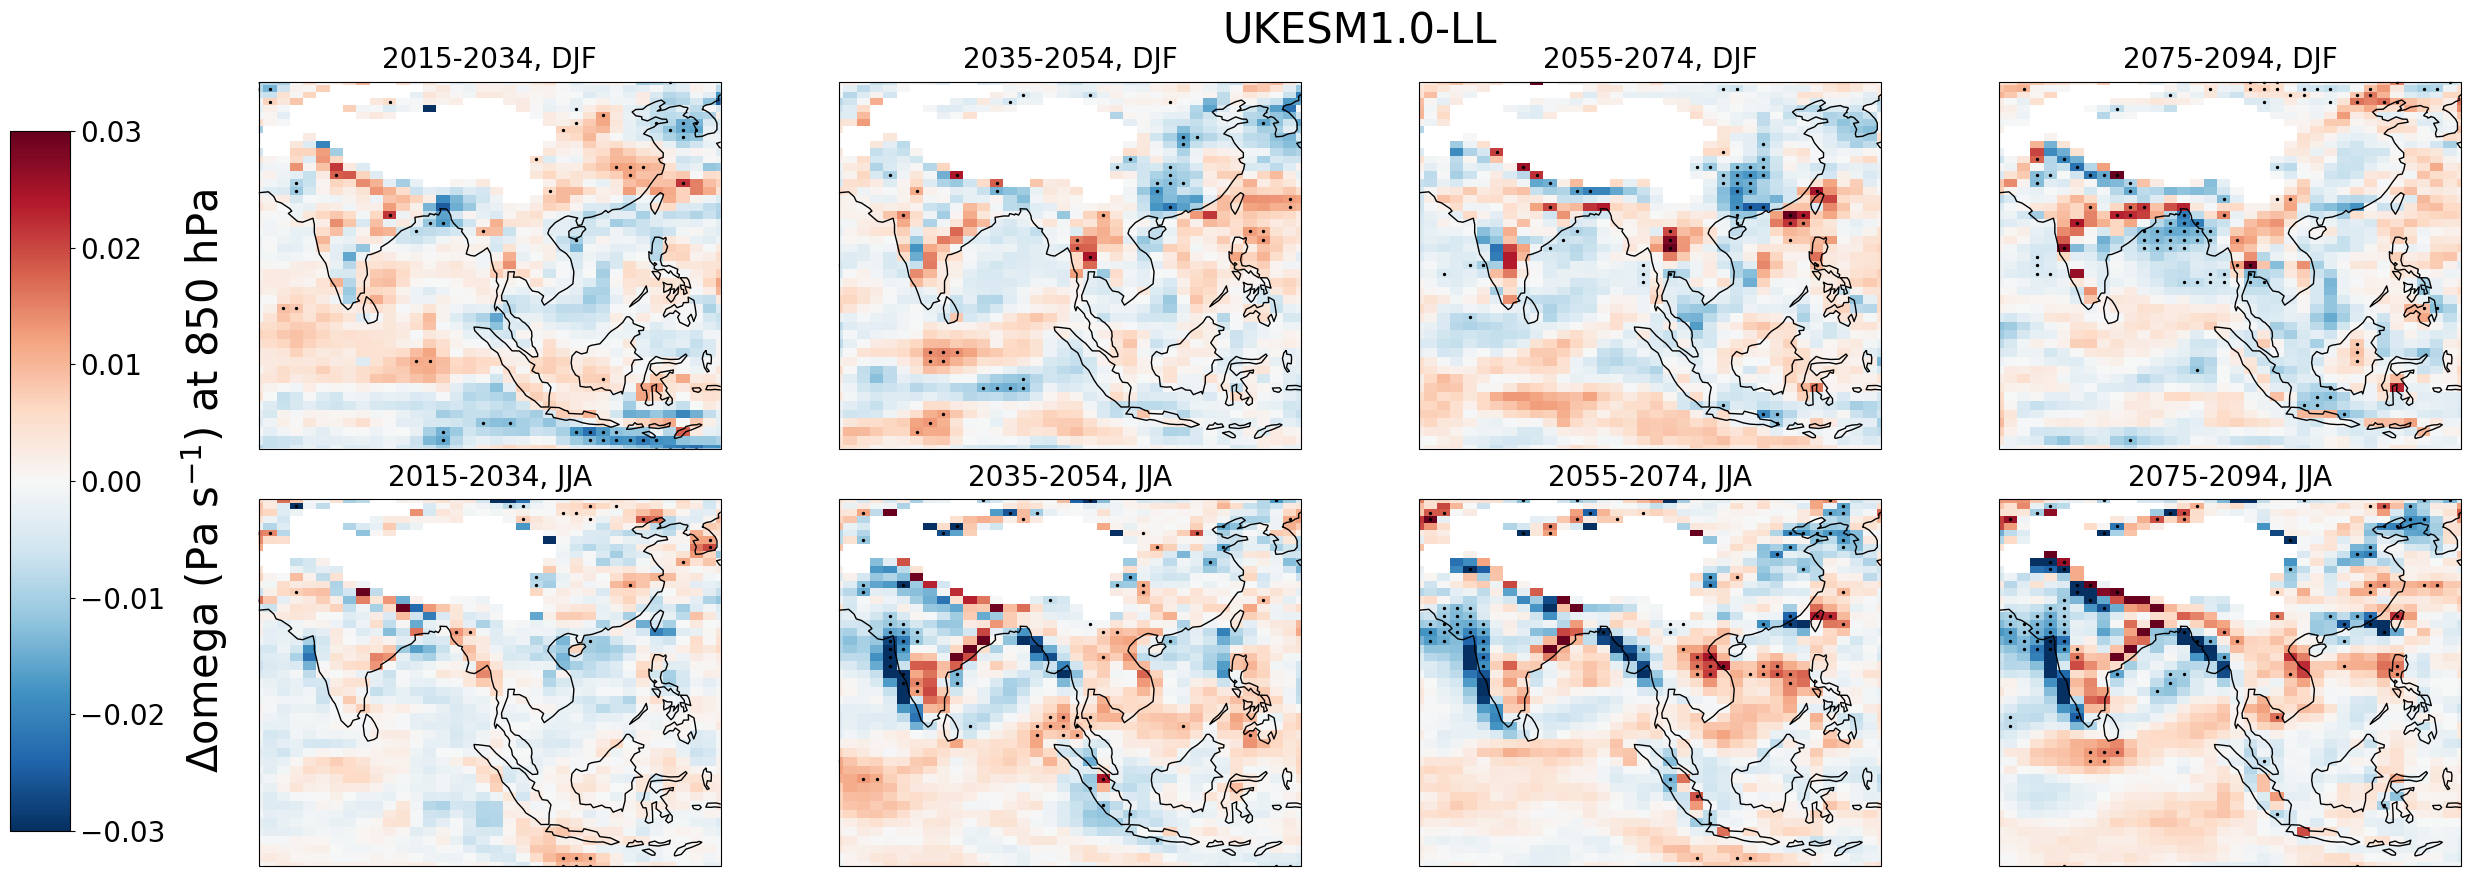

In [15]:
# Create the grid of subplots for UKESM with seasons in rows
fig, axes = plt.subplots(len(seasons), len(UKESM_intervals), figsize=(30, 10), 
                         subplot_kw={'projection': ccrs.LambertCylindrical()})


def plot_data(ax, anomaly, title, seasonal_base, seasonal_signal):
    # Set geographical extents [lon_min, lon_max, lat_min, lat_max]
    ax.set_extent([65, 130, -10, 40])
    im = anomaly.plot(ax=ax, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)
    ax.coastlines()
    ax.set_title(title, fontsize=20, pad=10)

    # Perform t-test
    t_stat, p_value = ttest_ind(seasonal_base['wap'].values,
                                seasonal_signal['wap'].values,
                                axis=0, nan_policy='omit')

    alpha = 0.05
    significant_points_mask = p_value < alpha

    lon, lat = np.meshgrid(seasonal_base['lon'].values, seasonal_base['lat'].values)
    ax.scatter(lon[significant_points_mask], lat[significant_points_mask], c='k', s=2, transform=ccrs.PlateCarree())

    return im

# Plotting for UKESM
last_im = None
for j, season in enumerate(seasons):
    for i, (start_year, end_year) in enumerate(UKESM_intervals):
        ax = axes[j, i]
        seasonal_base = UKESM_base_850.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30")).sel(time=UKESM_base.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"))['time'].dt.season == season)
        seasonal_signal = UKESM_signal_850.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30")).sel(time=UKESM_signal.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"))['time'].dt.season == season)

        # Calculate anomaly
        anomaly = calculate_seasonal_anomaly(start_year, end_year, UKESM_base_850, UKESM_signal_850, season)

        last_im = plot_data(ax, anomaly, f'{start_year}-{end_year}, {season}',
                            seasonal_base, seasonal_signal)

# Add a color bar
if last_im is not None:
    cbar_ax = fig.add_axes([0.05, 0.15, 0.02, 0.7])  # Place on the left side
    cbar = plt.colorbar(last_im, cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(r'$\Delta$omega (Pa s$^{-1}$) at 850 hPa', labelpad=10, fontsize=30)

fig.text(0.50, 0.95, 'UKESM1.0-LL', ha='center', va='center', fontsize=30)

# Adjust layout
fig.tight_layout(rect=[0.1, 0.1, 0.9, 0.95])
plt.show()


### MIROC and MPI-ESM

/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future 

/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/scipy/stats/_mstats_basic.py:1438: RuntimeWarning: divide by zero encountered in divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  value

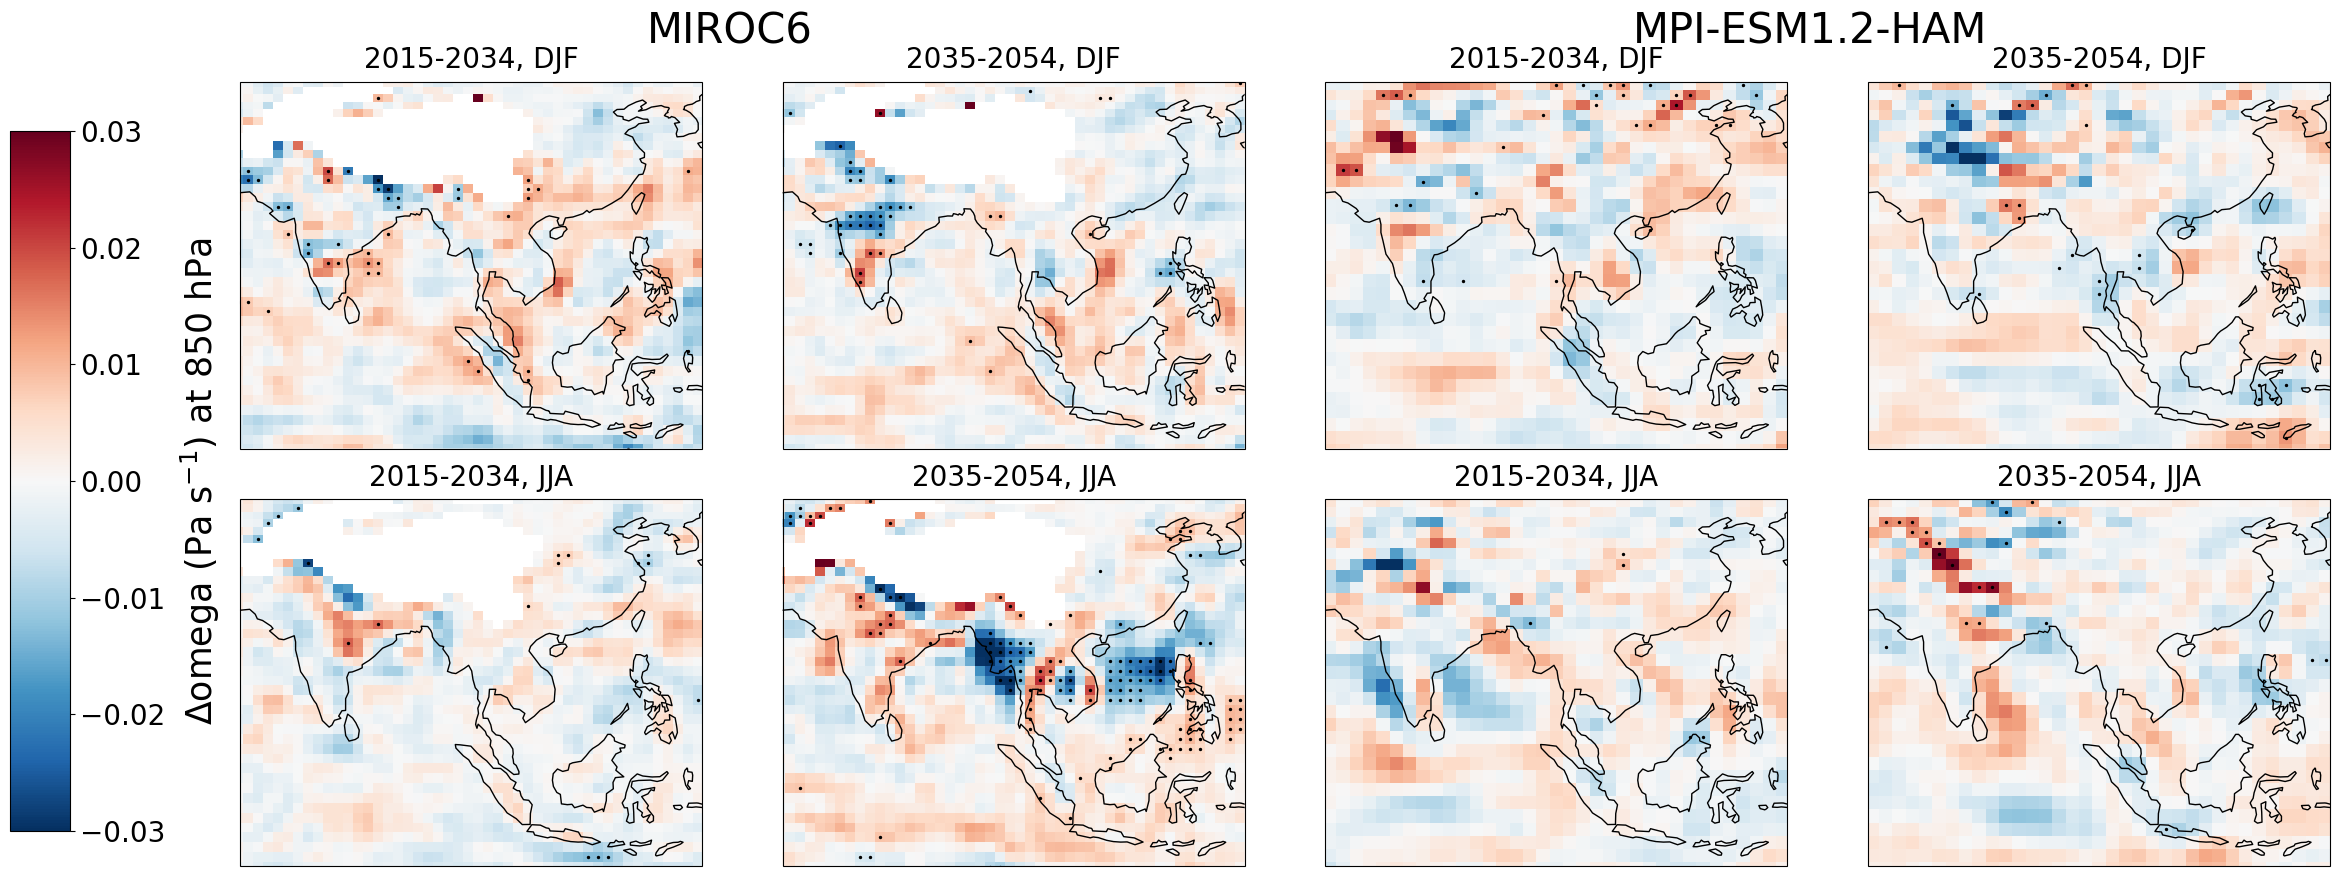

In [16]:
# Create the grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(30, 10), 
                         subplot_kw={'projection': ccrs.LambertCylindrical()})

# Flatten axes for easier indexing
axes = axes.flatten()

def plot_data(ax, anomaly, title, seasonal_base, seasonal_signal):
    # Set geographical extents [lon_min, lon_max, lat_min, lat_max]
    ax.set_extent([65, 130, -10, 40])
    im = anomaly.plot(ax=ax, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)
    ax.coastlines()
    ax.set_title(title, fontsize=20, pad=10)

    # Perform the t-test
    t_stat, p_value = ttest_ind(seasonal_base['wap'].values,
                                seasonal_signal['wap'].values,
                                axis=0, nan_policy='omit')

    alpha = 0.05
    significant_points_mask = p_value < alpha

    # Overlay significant points
    lon, lat = np.meshgrid(seasonal_base['lon'].values, seasonal_base['lat'].values)
    ax.scatter(lon[significant_points_mask], lat[significant_points_mask], c='k', s=2, transform=ccrs.PlateCarree())

    return im

for i, (start_year, end_year) in enumerate(MIROC6_intervals):
    for j, season in enumerate(seasons):
        ax = axes[j * 4 + i]
        anomaly = calculate_seasonal_anomaly(start_year, end_year, MIROC_base_850, MIROC_signal_850, season)
        seasonal_base = MIROC_base_850.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30")).sel(time=MIROC_base.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"))['time'].dt.season == season)
        seasonal_signal = MIROC_signal_850.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30")).sel(time=MIROC_signal.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"))['time'].dt.season == season)
        last_im = plot_data(ax, anomaly, f'{start_year}-{end_year}, {season}', 
                            seasonal_base, seasonal_signal)

# Loop through intervals and seasons for MPI-ESM
for i, (start_year, end_year) in enumerate(MPI_ESM_intervals):
    for j, season in enumerate(seasons):
        ax = axes[j * 4 + i + 2]  # Shift the index for MPI-ESM plots to the right
        anomaly = calculate_seasonal_anomaly(start_year, end_year, MPI_ESM_base_850, MPI_ESM_signal_850, season)
        seasonal_base = MPI_ESM_base_850.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30")).sel(time=MPI_ESM_base.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"))['time'].dt.season == season)
        seasonal_signal = MPI_ESM_signal_850.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30")).sel(time=MPI_ESM_signal.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"))['time'].dt.season == season)
        last_im = plot_data(ax, anomaly, f'{start_year}-{end_year}, {season}', 
                            seasonal_base, seasonal_signal)

# Add a color bar
if last_im is not None:
    cbar_ax = fig.add_axes([0.1, 0.15, 0.02, 0.7])  # Place on the left side
    cbar = plt.colorbar(last_im, cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(r'$\Delta$omega (Pa s$^{-1}$) at 850 hPa', labelpad=10, fontsize=25)
    
# Add headers for MIROC6 and MPI-ESM1.2-HAM
fig.text(0.34, 0.95, 'MIROC6', ha='center', va='center', fontsize=30)
fig.text(0.70, 0.95, 'MPI-ESM1.2-HAM', ha='center', va='center', fontsize=30)

# Adjust layout
fig.tight_layout(rect=[0.15, 0.1, 0.9, 0.95])

plt.show()

## 250 hPa

In [17]:
UKESM_anomalies = [calculate_anomaly(start, end, UKESM_base_250, UKESM_signal_250) for start, end in UKESM_intervals]
MIROC6_anomalies = [calculate_anomaly(start, end, MIROC_base_250, MIROC_signal_250) for start, end in MIROC6_intervals]
MPI_ESM_anomalies = [calculate_anomaly(start, end, MPI_ESM_base_250, MPI_ESM_signal_250) for start, end in MPI_ESM_intervals]

### UKESM

/tmp/ipykernel_1681763/106122615.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0.1, 0.1, 0.9, 0.95])


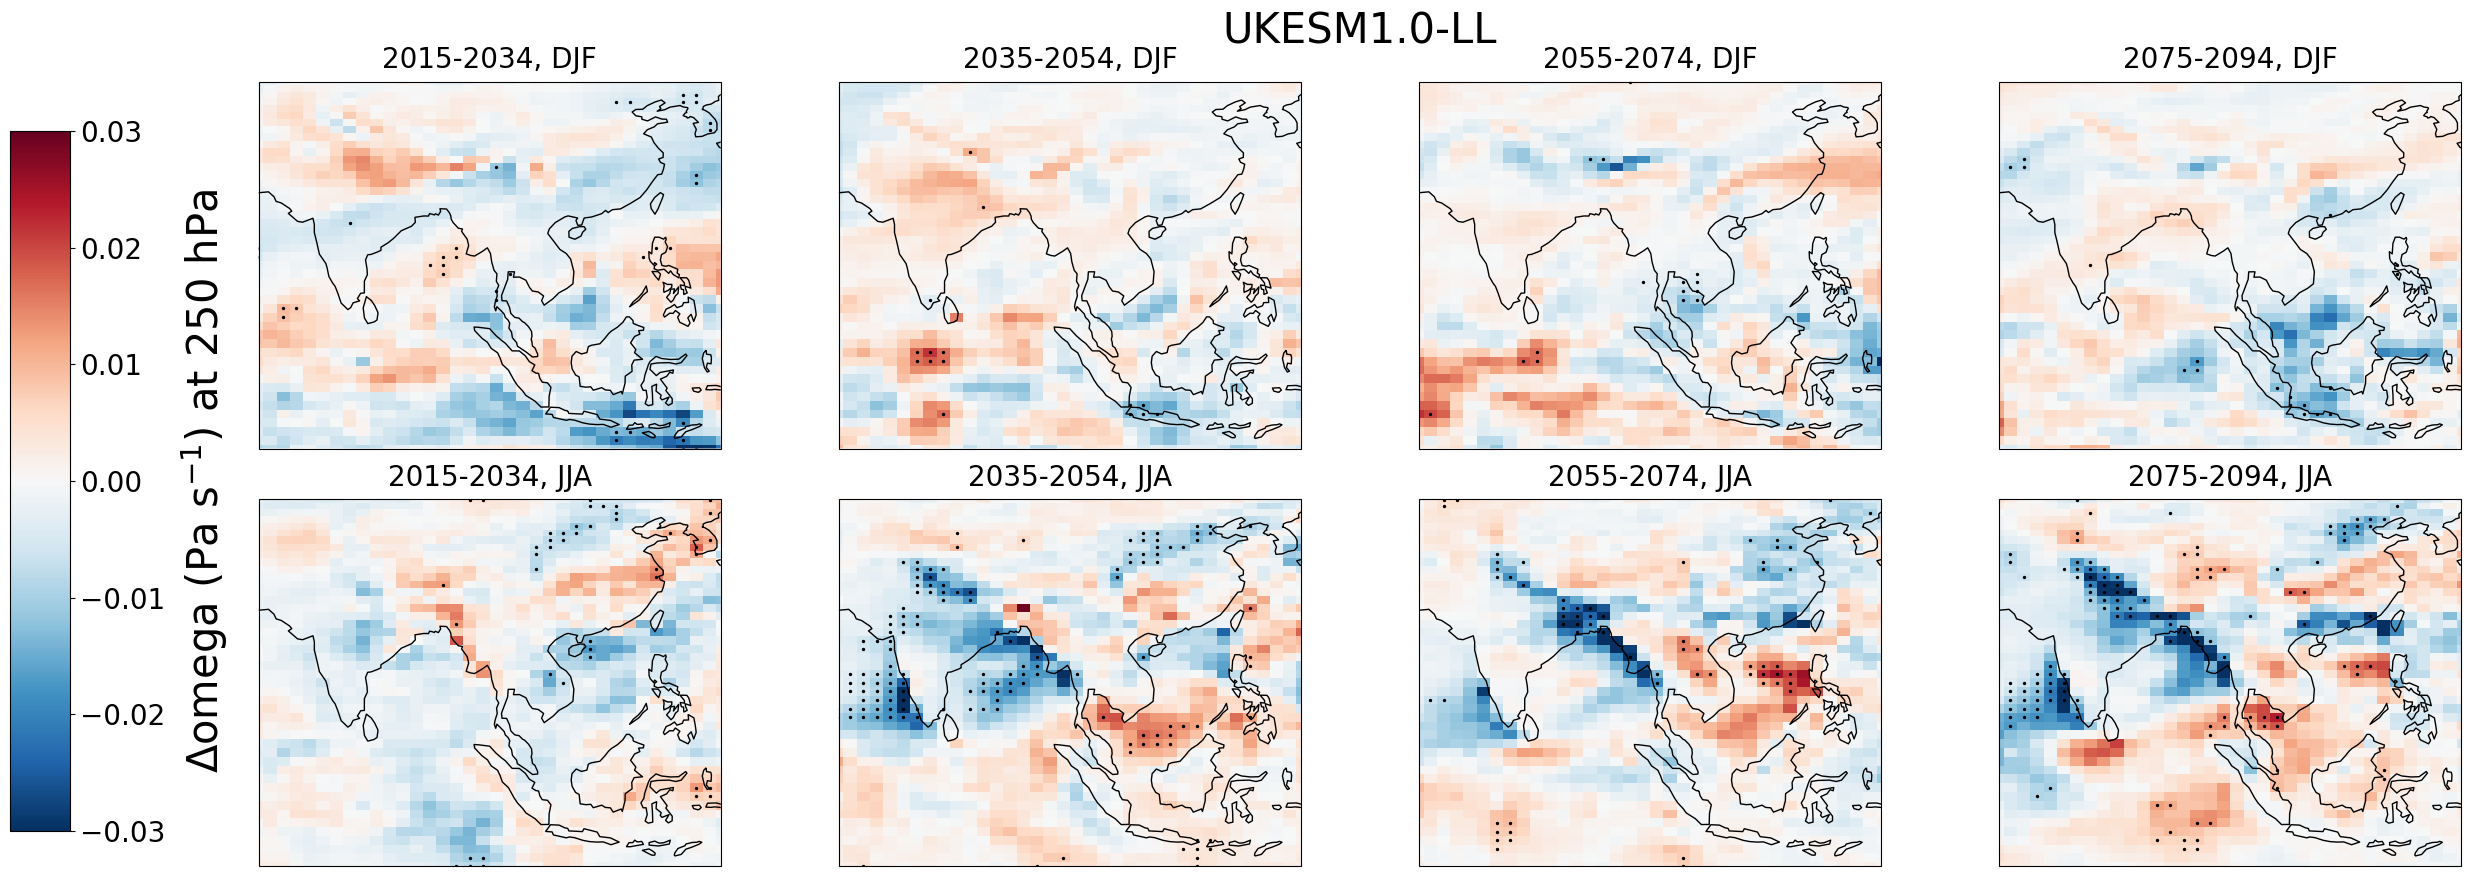

In [18]:
# Create the grid of subplots for UKESM with seasons in rows
fig, axes = plt.subplots(len(seasons), len(UKESM_intervals), figsize=(30, 10), 
                         subplot_kw={'projection': ccrs.LambertCylindrical()})


def plot_data(ax, anomaly, title, seasonal_base, seasonal_signal):
    # Set geographical extents [lon_min, lon_max, lat_min, lat_max]
    ax.set_extent([65, 130, -10, 40])
    im = anomaly.plot(ax=ax, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)
    ax.coastlines()
    ax.set_title(title, fontsize=20, pad=10)

    # Perform t-test
    t_stat, p_value = ttest_ind(seasonal_base['wap'].values,
                                seasonal_signal['wap'].values,
                                axis=0, nan_policy='omit')

    alpha = 0.05
    significant_points_mask = p_value < alpha

    lon, lat = np.meshgrid(seasonal_base['lon'].values, seasonal_base['lat'].values)
    ax.scatter(lon[significant_points_mask], lat[significant_points_mask], c='k', s=2, transform=ccrs.PlateCarree())

    return im

# Plotting for UKESM
last_im = None
for j, season in enumerate(seasons):
    for i, (start_year, end_year) in enumerate(UKESM_intervals):
        ax = axes[j, i]
        seasonal_base = UKESM_base_250.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30")).sel(time=UKESM_base.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"))['time'].dt.season == season)
        seasonal_signal = UKESM_signal_250.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30")).sel(time=UKESM_signal.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"))['time'].dt.season == season)

        # Calculate anomaly
        anomaly = calculate_seasonal_anomaly(start_year, end_year, UKESM_base_250, UKESM_signal_250, season)

        last_im = plot_data(ax, anomaly, f'{start_year}-{end_year}, {season}',
                            seasonal_base, seasonal_signal)

# Add a color bar
if last_im is not None:
    cbar_ax = fig.add_axes([0.05, 0.15, 0.02, 0.7])  # Place on the left side
    cbar = plt.colorbar(last_im, cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(r'$\Delta$omega (Pa s$^{-1}$) at 250 hPa', labelpad=10, fontsize=30)

fig.text(0.50, 0.95, 'UKESM1.0-LL', ha='center', va='center', fontsize=30)

# Adjust layout
fig.tight_layout(rect=[0.1, 0.1, 0.9, 0.95])
plt.show()


### MIROC and MPI-ESM

/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future 

/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future 

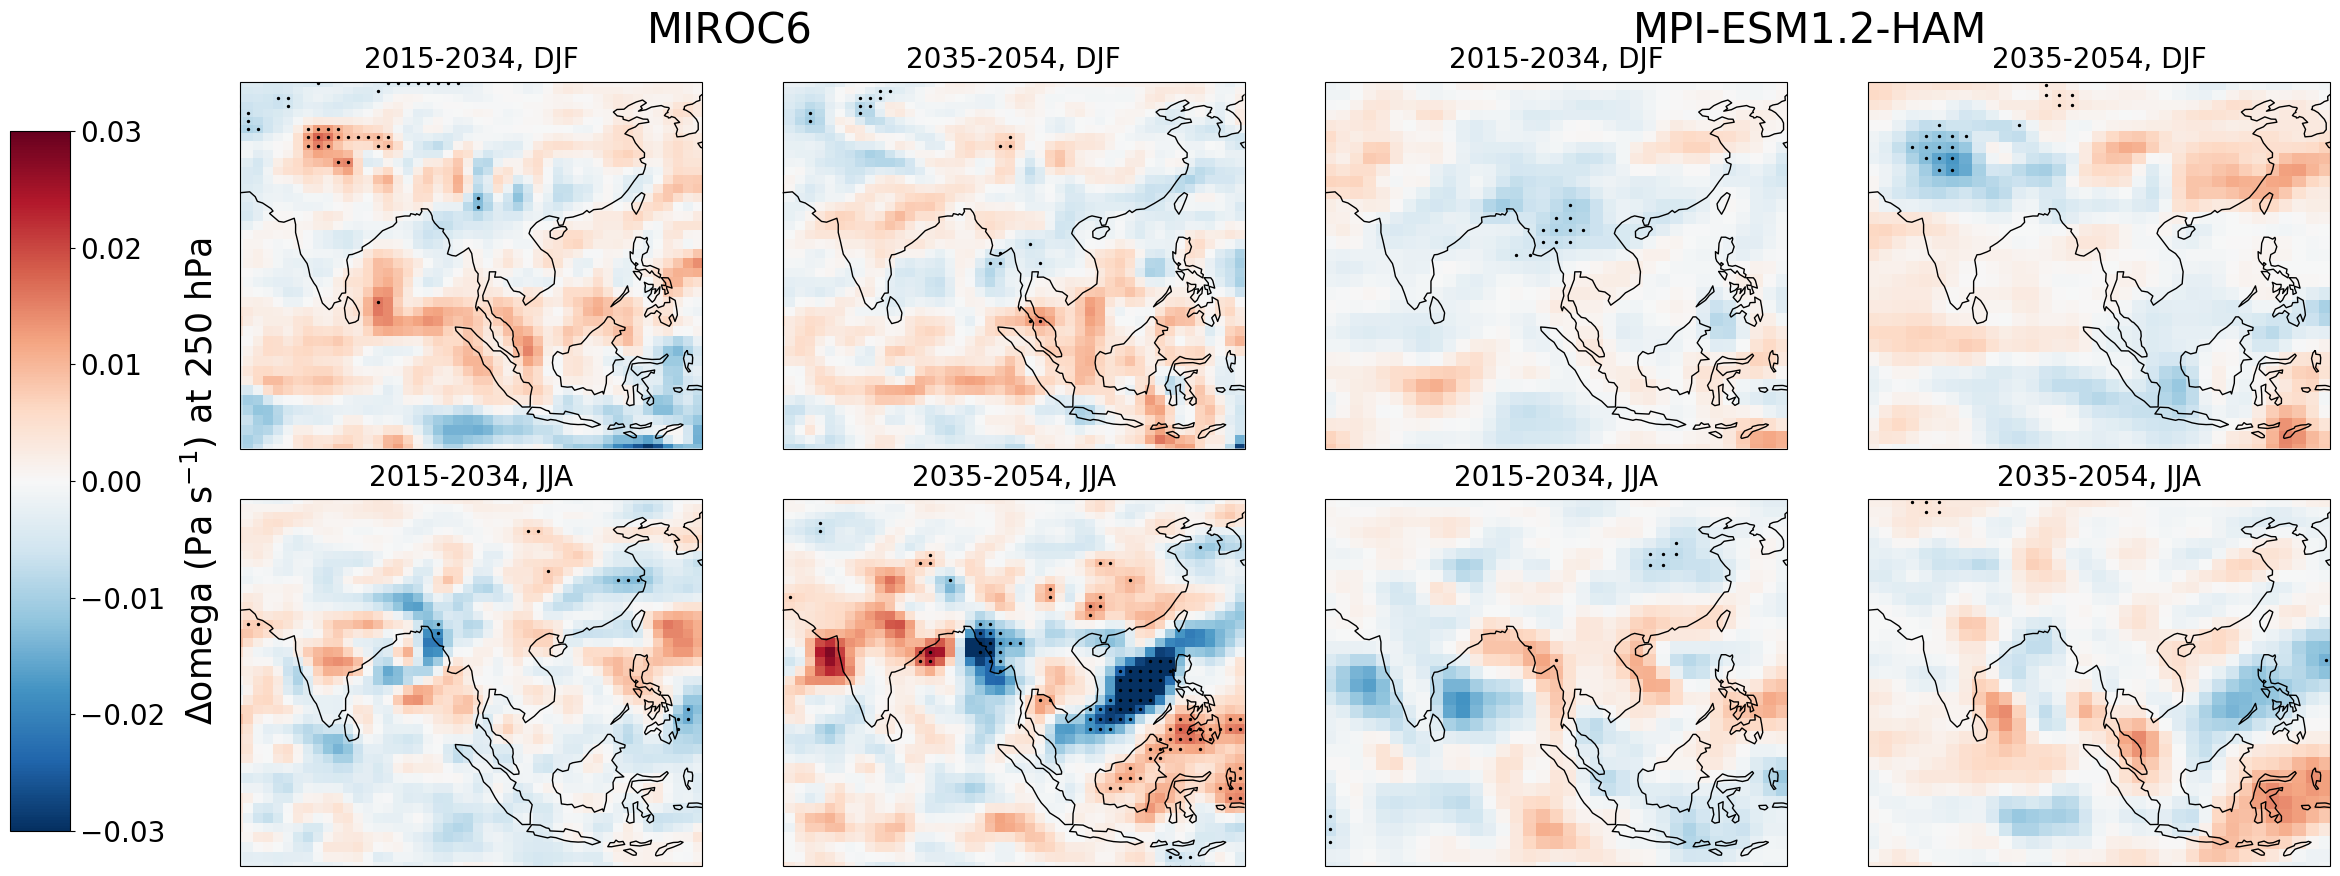

In [19]:
# Create the grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(30, 10), 
                         subplot_kw={'projection': ccrs.LambertCylindrical()})

# Flatten axes for easier indexing
axes = axes.flatten()

def plot_data(ax, anomaly, title, seasonal_base, seasonal_signal):
    # Set geographical extents [lon_min, lon_max, lat_min, lat_max]
    ax.set_extent([65, 130, -10, 40])
    im = anomaly.plot(ax=ax, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)
    ax.coastlines()
    ax.set_title(title, fontsize=20, pad=10)

    # Perform the t-test
    t_stat, p_value = ttest_ind(seasonal_base['wap'].values,
                                seasonal_signal['wap'].values,
                                axis=0, nan_policy='omit')

    alpha = 0.05
    significant_points_mask = p_value < alpha

    # Overlay significant points
    lon, lat = np.meshgrid(seasonal_base['lon'].values, seasonal_base['lat'].values)
    ax.scatter(lon[significant_points_mask], lat[significant_points_mask], c='k', s=2, transform=ccrs.PlateCarree())

    return im

for i, (start_year, end_year) in enumerate(MIROC6_intervals):
    for j, season in enumerate(seasons):
        ax = axes[j * 4 + i]
        anomaly = calculate_seasonal_anomaly(start_year, end_year, MIROC_base_250, MIROC_signal_250, season)
        seasonal_base = MIROC_base_250.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30")).sel(time=MIROC_base.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"))['time'].dt.season == season)
        seasonal_signal = MIROC_signal_250.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30")).sel(time=MIROC_signal.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"))['time'].dt.season == season)
        last_im = plot_data(ax, anomaly, f'{start_year}-{end_year}, {season}', 
                            seasonal_base, seasonal_signal)

# Loop through intervals and seasons for MPI-ESM
for i, (start_year, end_year) in enumerate(MPI_ESM_intervals):
    for j, season in enumerate(seasons):
        ax = axes[j * 4 + i + 2]  # Shift the index for MPI-ESM plots to the right
        anomaly = calculate_seasonal_anomaly(start_year, end_year, MPI_ESM_base_250, MPI_ESM_signal_250, season)
        seasonal_base = MPI_ESM_base_250.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30")).sel(time=MPI_ESM_base.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"))['time'].dt.season == season)
        seasonal_signal = MPI_ESM_signal_250.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30")).sel(time=MPI_ESM_signal.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"))['time'].dt.season == season)
        last_im = plot_data(ax, anomaly, f'{start_year}-{end_year}, {season}', 
                            seasonal_base, seasonal_signal)

# Add a color bar
if last_im is not None:
    cbar_ax = fig.add_axes([0.1, 0.15, 0.02, 0.7])  # Place on the left side
    cbar = plt.colorbar(last_im, cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(r'$\Delta$omega (Pa s$^{-1}$) at 250 hPa', labelpad=10, fontsize=25)
    
# Add headers for MIROC6 and MPI-ESM1.2-HAM
fig.text(0.34, 0.95, 'MIROC6', ha='center', va='center', fontsize=30)
fig.text(0.70, 0.95, 'MPI-ESM1.2-HAM', ha='center', va='center', fontsize=30)

# Adjust layout
fig.tight_layout(rect=[0.15, 0.1, 0.9, 0.95])

plt.show()